## Imports

In [1]:
import gc
import PIL

from contextlib import contextmanager
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

from tqdm import tnrange, tqdm_notebook
from IPython.display import clear_output

In [2]:
INTERACTIVE = True

## Utils

In [3]:
@contextmanager
def eval_mode(module):
    """Context manager for putting a module into eval mode and back."""
    module.eval()
    yield
    module.train()

In [4]:
def get_module(module, attr_str):
    """Emulate an `operator.attrgetter` call for PyTroch modules."""
    for attr in attr_str.split('.'):
        module = module._modules[attr]
    else:
        return module

In [5]:
@contextmanager
def draw_helper(*args, **kwargs):
    """Cleanup helper for subplot drawing."""
    fig, axes = plt.subplots(*args, **kwargs)
    
    yield fig, axes
    
    if INTERACTIVE:
        clear_output(wait=True)
        
    fig.patch.set_alpha(0.)
    plt.tight_layout()
    plt.show()

## Data

In [6]:
DATA  = Path('/kaggle/input')
DATA /= 'fruits/fruits-360_dataset/fruits-360'
assert DATA.exists()

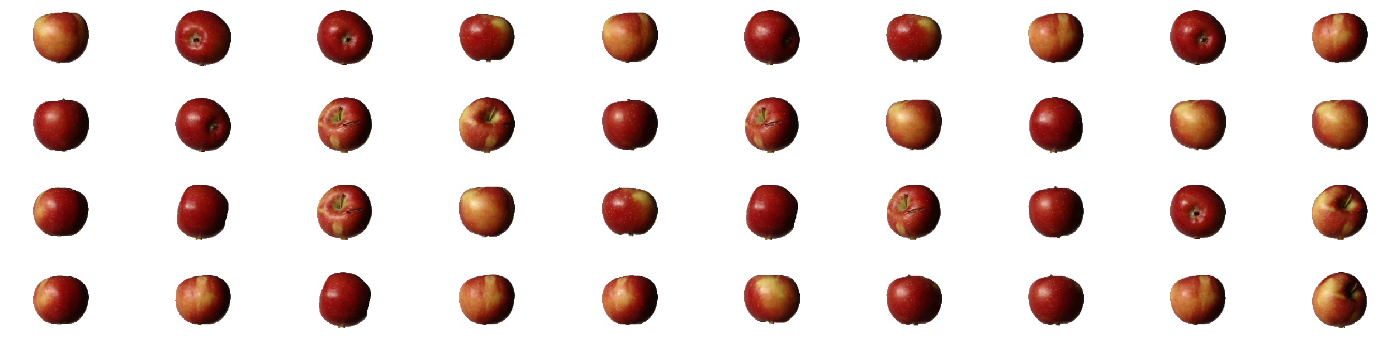

In [7]:
path = DATA/'Training/Apple Braeburn'

with draw_helper(4, 10, figsize=(20, 5)) as (fig, axes):
    gen = zip(path.glob('*'), axes.flat)
    for x, ax in tqdm_notebook(gen, total=40):
        x = PIL.Image.open(x)
        ax.imshow(x)
        ax.axis('off')

## Hooks and Feature Maps

In [8]:
resnet18 = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 29245081.26it/s]


In [9]:
class Hook(object):
    """
    Simple PyTorch Hook.
    """
    def __init__(self, module, forward=True):
        if forward:
            attr = 'register_forward_hook'
        else:
            attr = 'register_backward_hook'
        
        attr = getattr(module, attr)
        self._hook = attr(self._hook_fn)
    
    def __enter__(self):
        return self
    
    def __exit__(self, *_):
        self.remove()
        
    def _hook_fn(self, module, input, output):
        self.input = input
        self.output = output
        
    def remove(self):
        self._hook.remove()

In [10]:
x.resize([64, 64])
x = torch.from_numpy(np.asarray(x))
x = x.permute(-1, 0, 1).unsqueeze(0).float()

m = get_module(resnet18, 'layer1.0.conv2')

with torch.no_grad():
    with eval_mode(resnet18):
        with Hook(m) as hook:
            # dummy forward pass
            resnet18(x)

print('Output hooked and stored!')

Output hooked and stored!


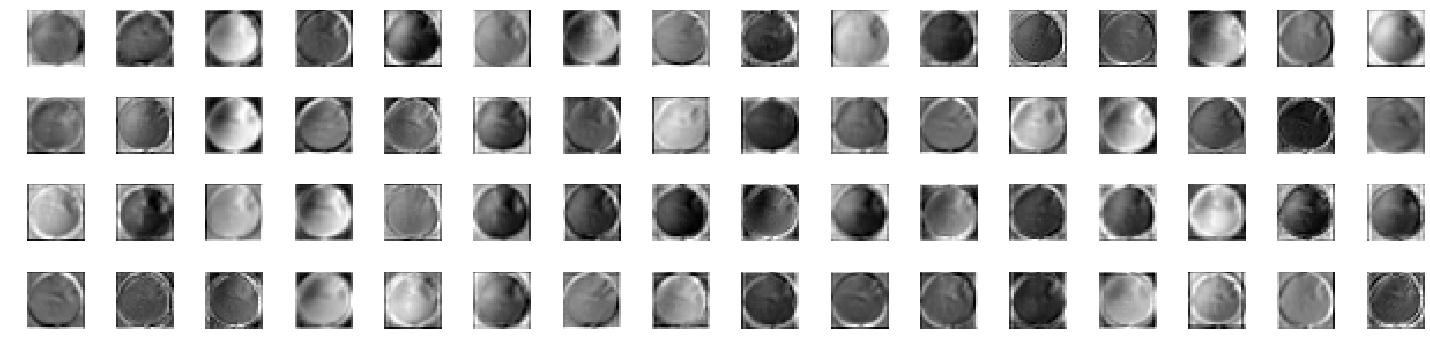

In [11]:
with draw_helper(4, 16, figsize=(20, 5)) as (fig, axes):
    maps = hook.output.squeeze()
    gen = zip(maps, axes.flat)
    for x, ax in tqdm_notebook(gen, total=64):
        ax.imshow(x, cmap='binary')
        ax.axis('off')

## Activation Patterns

In [12]:
INTERACTIVE = False

In [13]:
def cleanup(x):
    """Clean up the output of `get_pattern`."""
    o  = x.squeeze().transpose(1, 2, 0)
    o -= o.mean()
    o /= o.std()
    o  = np.clip(o, 0, 1)
    
    return np.clip(o * 255, 0, 255).astype(np.uint8)

In [14]:
def get_pattern(module, channel_id, *, lr=3, epochs=25):
    """Return a pattern that the selected channel of a module is most responsive to."""
    # Initial random image (B x C x H x W)
    x = torch.randn(1, 3, 64, 64)
    x.requires_grad_(True)

    opt = torch.optim.SGD([x], lr=lr)
    
    with eval_mode(resnet18):
        with Hook(module) as hook:
            bar = tnrange if INTERACTIVE else range
            bar = bar(epochs)
            for _ in bar:
                resnet18(x)

                out = hook.output.squeeze()
                out = out[channel_id]
                
                # maximize the magnitude of layer activations
                loss = out.sum().abs().neg()
                loss.backward()
                opt.step()
                
                if INTERACTIVE:
                    bar.desc = f'Loss: {loss.item():.3f}'
            else:
                return x.detach().numpy()

In [15]:
def draw_multiple_patterns(model, layer, channel_ids, max_cols=8, figsize=(20, 3)):
    """Draw multiple patterns from the selected layer."""
    module = get_module(model, layer)

    idx = channel_ids
    if isinstance(channel_ids, (range, slice)):
        args = [
            idx.start or 0,
            None or idx.stop,
            idx.step or 1,
        ]
        idx = tuple(range(*args))

    n = len(idx)
    r = max(1, n // max_cols)
    c = min(n, max_cols) 
    
    with draw_helper(r, c, figsize=figsize) as (fig, axes):
        for i, ax in zip(idx, axes.flat):
            try:
                x = get_pattern(module, i)
            except IndexError:
                break
            else:
                ax.imshow(cleanup(x))
                ax.set_title(i)
                ax.axis('off')
                if INTERACTIVE:
                    clear_output(wait=True)
        else:
            kwargs = {
                'va': 'bottom', 
                'size': 'large', 
                'weight': 'demibold',
            }
            fig.suptitle(layer, **kwargs)

## Layer 1 (complete)

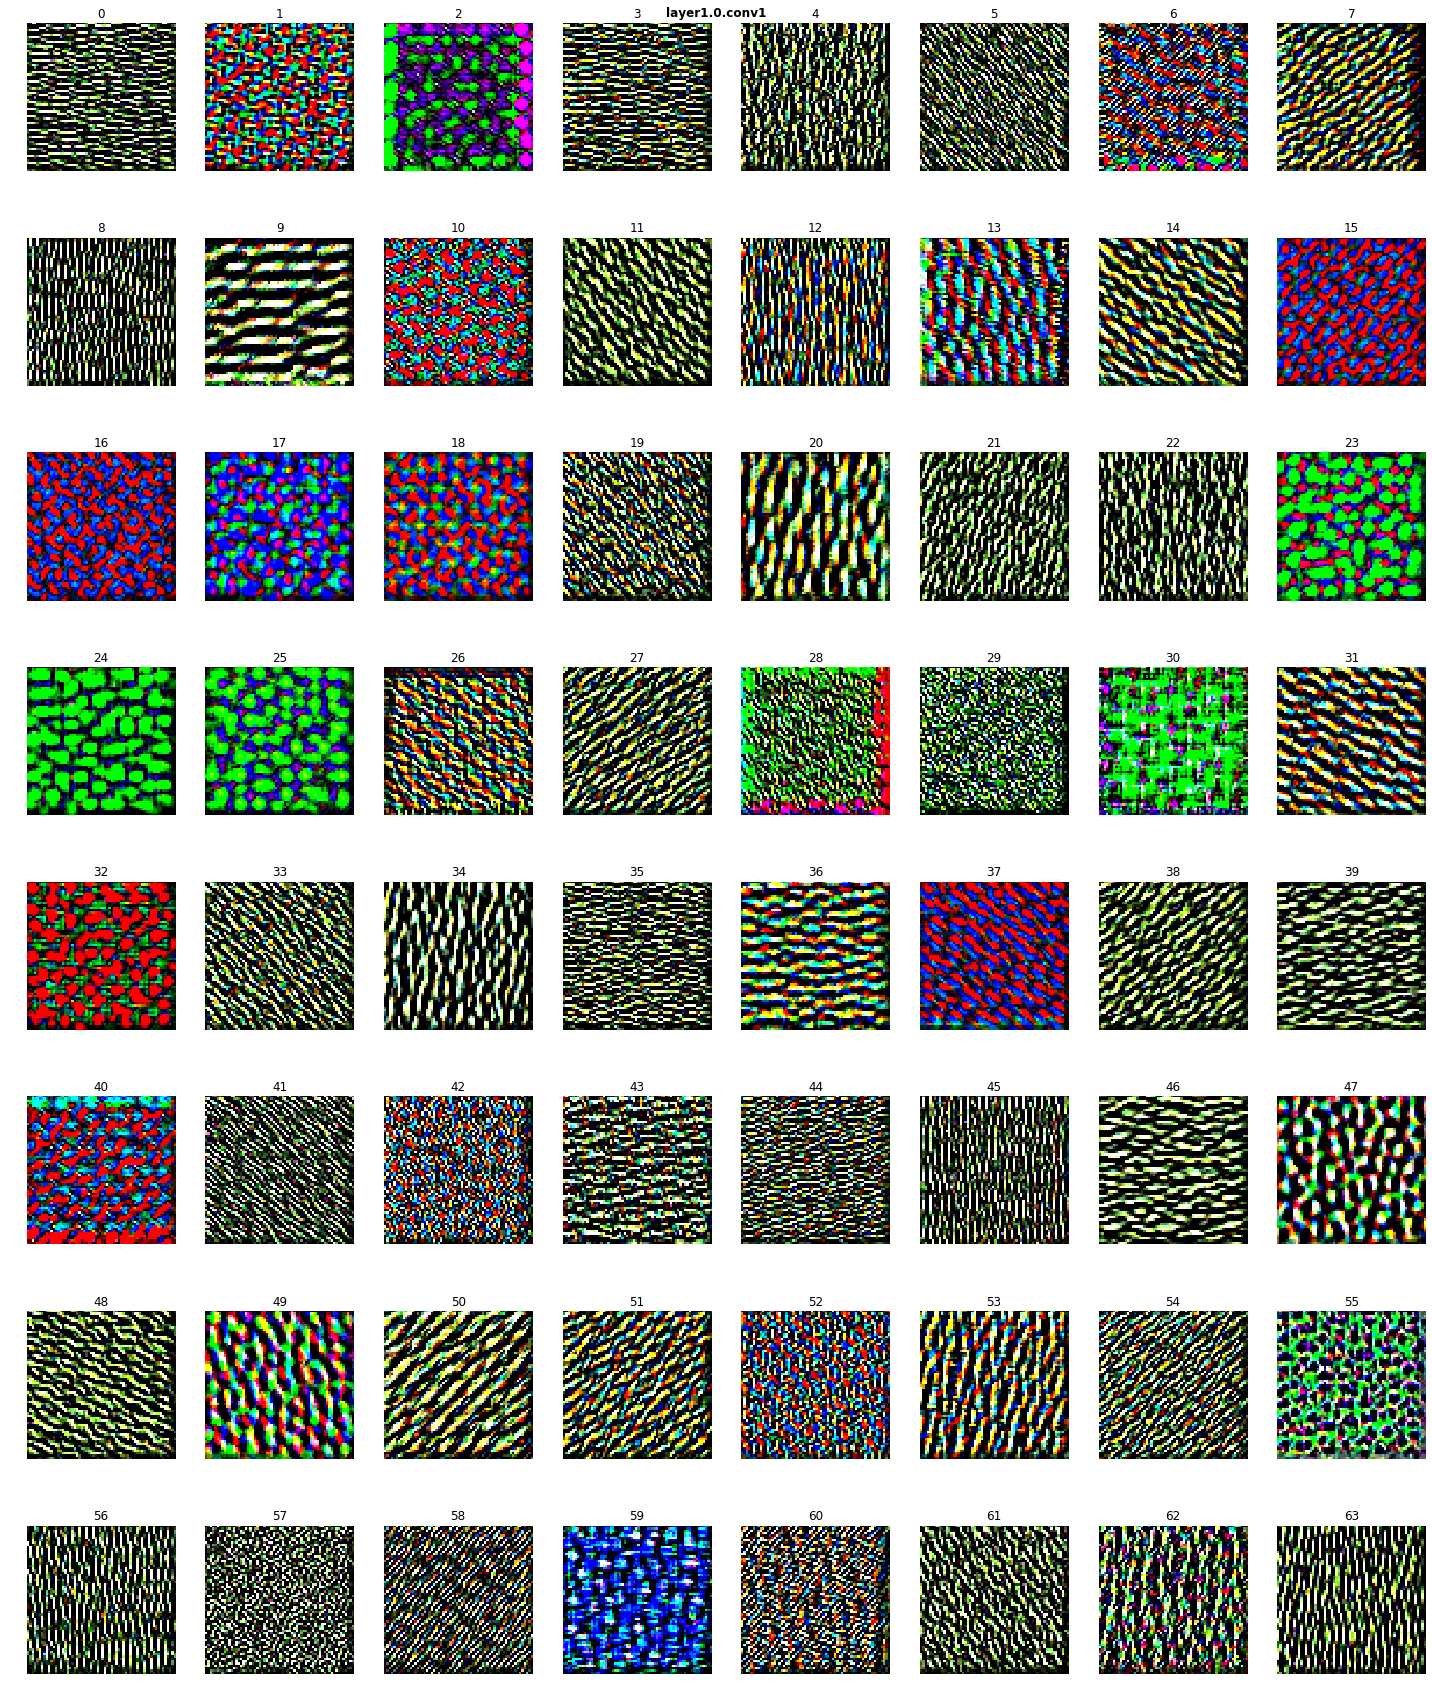

In [16]:
# all the basic patterns of the very first convolutional layer
draw_multiple_patterns(resnet18, 'layer1.0.conv1', range(0, 64), figsize=(20, 24))

## Layers 1-4

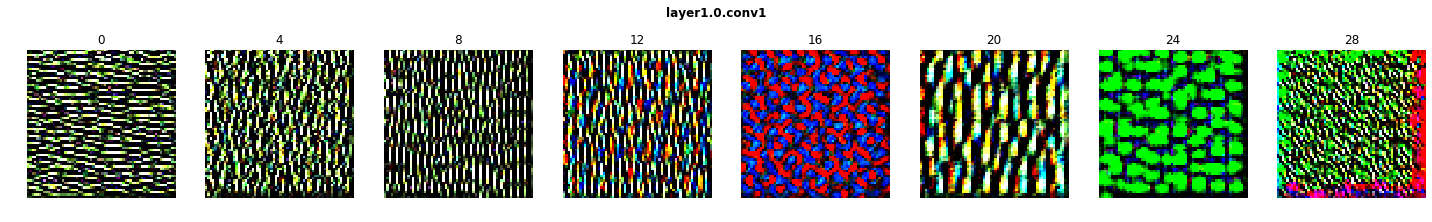

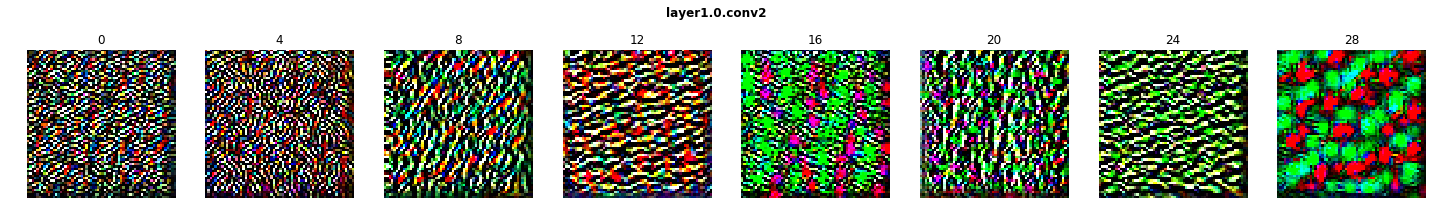

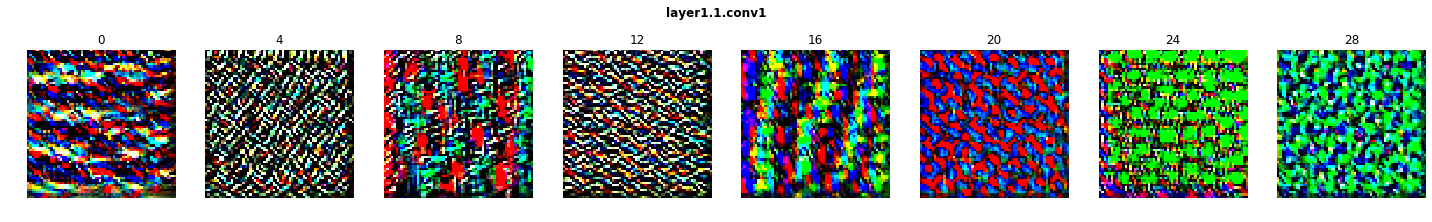

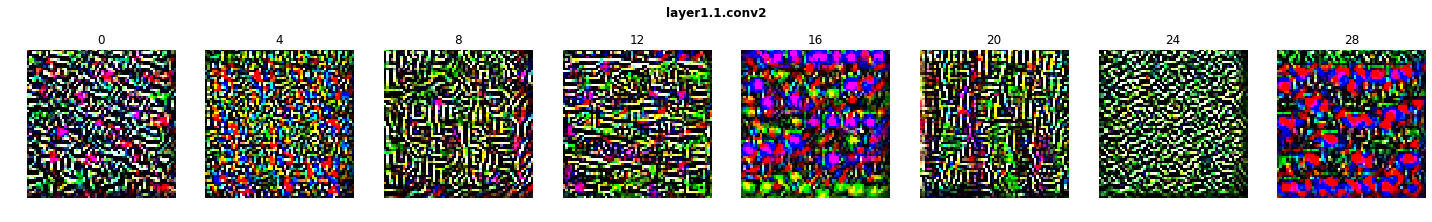

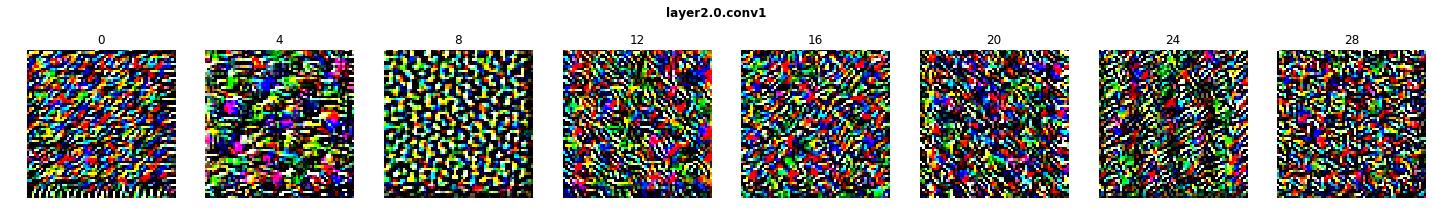

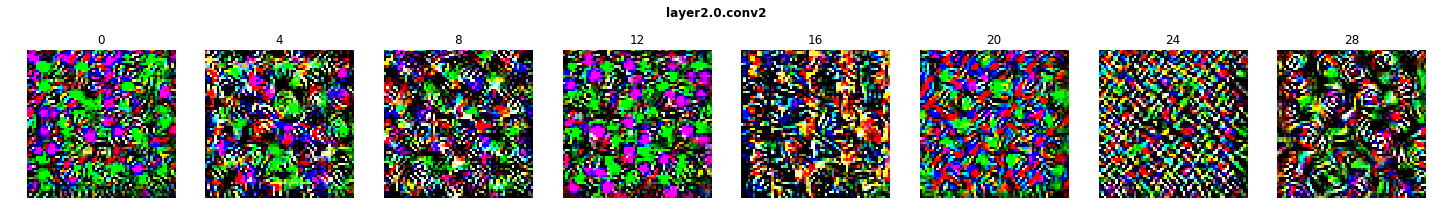

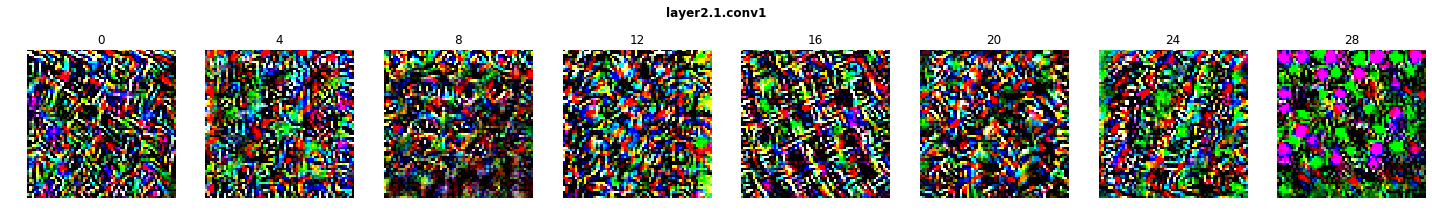

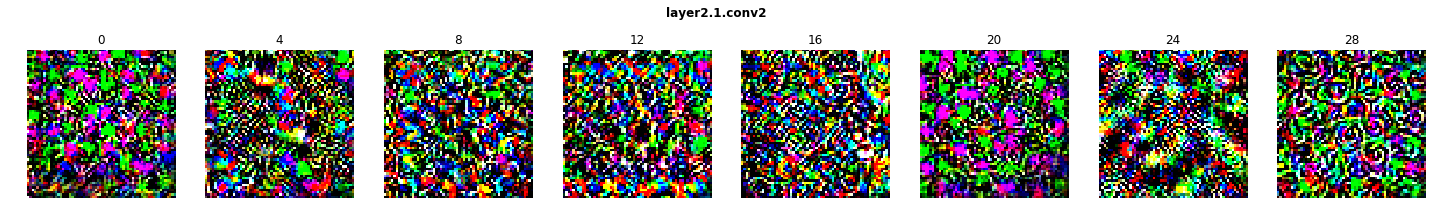

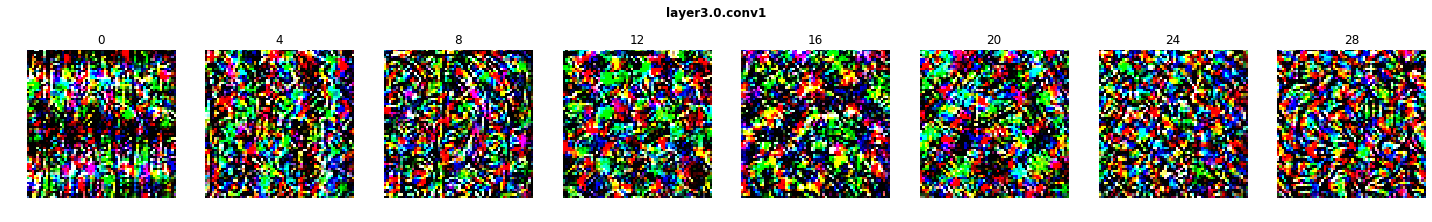

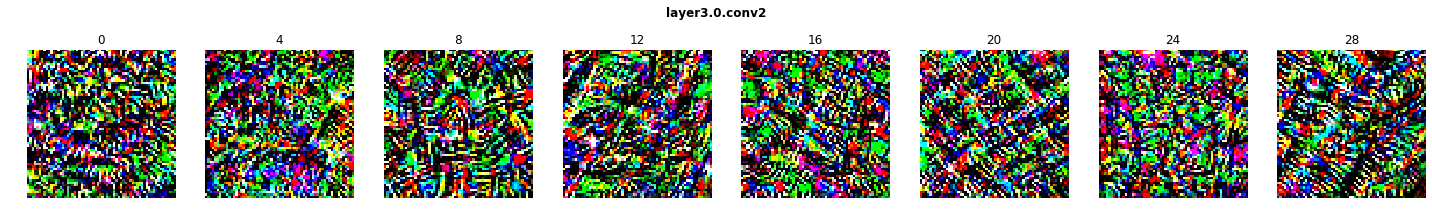

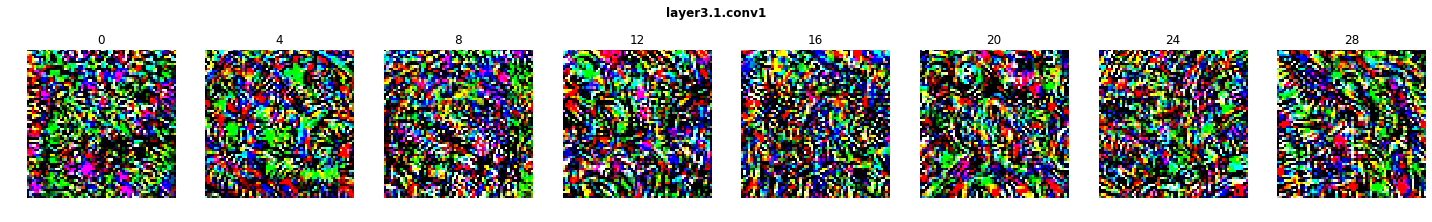

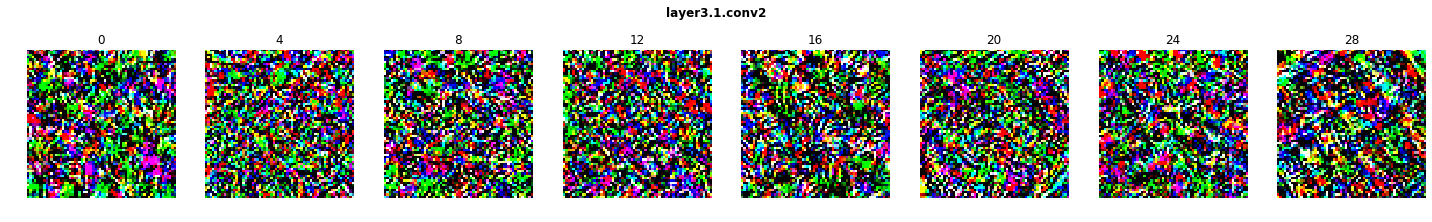

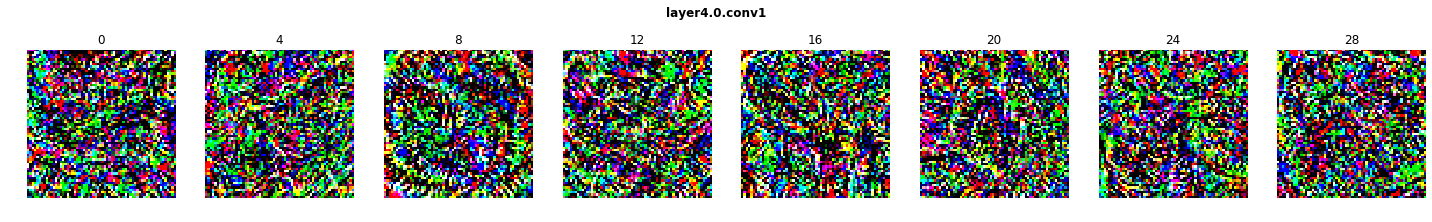

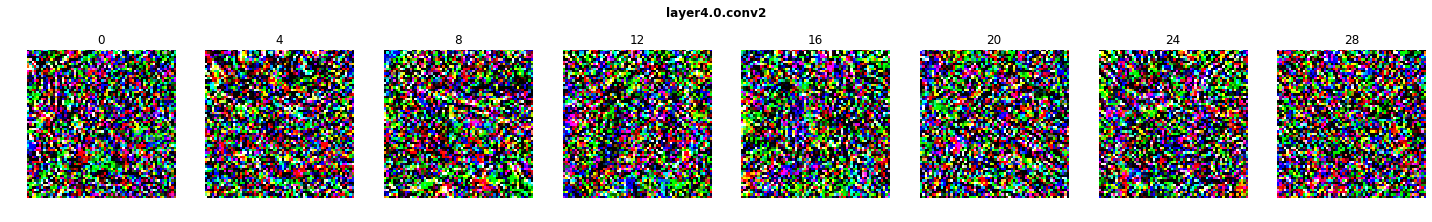

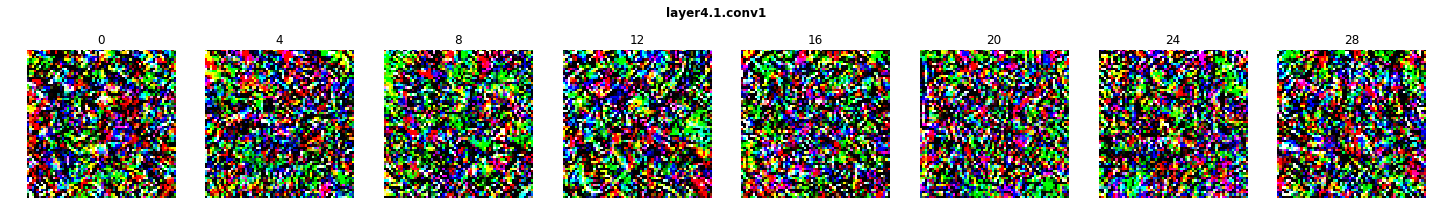

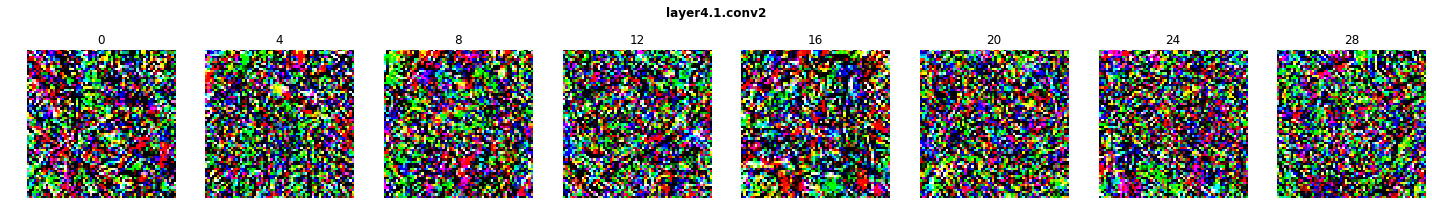

In [17]:
# a snapshot of patterns from each layer
layers = [f'layer{i}.{j}.conv{k}' 
          for i in range(1, 5)
          for j in range(2)
          for k in range(1, 3)]
kwargs = {
    'channel_ids': range(0, 32, 4),
    'figsize': (20, 3),
}
for layer in tqdm_notebook(layers):
    draw_multiple_patterns(resnet18, layer, **kwargs)

**fin**